Models Implementation****

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

class BasicAutoencoder(nn.Module):
    def __init__(self, input_dim):
        super(BasicAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


class SparseAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim = 10, sparsity_param=0.05, beta=1):
        super(SparseAutoencoder, self).__init__()
        self.encoder = nn.Linear(input_dim, hidden_dim)
        self.decoder = nn.Linear(hidden_dim, input_dim)
        self.sparsity_param = sparsity_param
        self.beta = beta
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        z = self.sigmoid(self.encoder(x))
        x_hat = self.sigmoid(self.decoder(z))
        return x_hat, z

    def sparsity_loss(self, z):
        rho_hat = torch.mean(z, dim=0)
        rho = self.sparsity_param
        kl_div = rho * torch.log(rho / (rho_hat + 1e-8)) + \
                 (1 - rho) * torch.log((1 - rho) / (1 - rho_hat + 1e-8))
        return self.beta * torch.sum(kl_div)


class DenoisingAutoencoder(nn.Module):
    def __init__(self, input_dim):
        super(DenoisingAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded



class VariationalAutoencoder(nn.Module):
    def __init__(self, input_dim):
        super(VariationalAutoencoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, 16)
        self.fc_mu = nn.Linear(16, 8)
        self.fc_logvar = nn.Linear(16, 8)
        
        self.fc3 = nn.Linear(8, 16)
        self.fc4 = nn.Linear(16, input_dim)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):
        h = self.relu(self.fc1(x))
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.relu(self.fc3(z))
        return self.sigmoid(self.fc4(h))

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_recon = self.decode(z)
        return x_recon, mu, log_var

class ConvolutionalAutoencoder(nn.Module):
    def __init__(self, input_dim):
        super(ConvolutionalAutoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=3, padding=1),  
            nn.ReLU(),
            nn.Conv1d(16, 8, kernel_size=3, padding=1),  
            nn.ReLU(),
            nn.MaxPool1d(2)                              
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(8, 16, kernel_size=2, stride=2), 
            nn.ReLU(),
            nn.Conv1d(16, 1, kernel_size=3, padding=1),         
            nn.Sigmoid()  
        )


    def forward(self, x):
        x = x.unsqueeze(1)  
        orig_len = x.shape[2]
    
        if orig_len % 2 != 0:
            x = nn.functional.pad(x, (0, 1))  
    
        z = self.encoder(x) 
        x_recon = self.decoder(z)
        x_recon = x_recon[:, :, :orig_len]
        return x_recon.squeeze(1)


Data Preprocessing****

In [18]:
import os
import joblib 

def prepare_dataset(filepath, device, dataset_name, fraud_to_normal_ratio=15, batch_size=64):
    data = pd.read_csv(filepath)

    if dataset_name != "credit_card":
        data["Class"] = (data["nr_alerts"] > 0).astype(int)
        
    normal_data = data[data['Class'] == 0]
    fraud_data = data[data['Class'] == 1]

    X_normal = normal_data.drop(columns=['Class'])
    y_normal = normal_data['Class']

    X_train_normal, X_temp_normal, y_train_normal, y_temp_normal = train_test_split(
        X_normal, y_normal, test_size=0.30, random_state=42
    )
    X_val_normal, X_test_normal, y_val_normal, y_test_normal = train_test_split(
        X_temp_normal, y_temp_normal, test_size=0.5, random_state=42
    )
    X_test_full = pd.concat([X_test_normal, fraud_data.drop(columns=['Class'])])
    y_test_full = pd.concat([y_test_normal, fraud_data['Class']])
    X_test_full, y_test_full = shuffle(X_test_full, y_test_full, random_state=42)

    n_frauds = fraud_data.shape[0]
    n_required_normals = n_frauds * fraud_to_normal_ratio
    X_balanced_normal = X_test_normal.sample(n=n_required_normals, random_state=42)
    y_balanced_normal = y_test_normal.loc[X_balanced_normal.index]
    X_test_balanced = pd.concat([X_balanced_normal, fraud_data.drop(columns=['Class'])])
    y_test_balanced = pd.concat([y_balanced_normal, fraud_data['Class']])
    X_test_balanced, y_test_balanced = shuffle(X_test_balanced, y_test_balanced, random_state=42)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_normal)
    X_val_scaled = scaler.transform(X_val_normal)
    X_test_full_scaled = scaler.transform(X_test_full)
    X_test_bal_scaled = scaler.transform(X_test_balanced)

    os.makedirs("scalers", exist_ok=True)
    joblib.dump(scaler, f"scalers/{dataset_name}_scaler.pkl")

    def to_tensors(X, y):
        return (
            torch.tensor(X, dtype=torch.float32).to(device),
            torch.tensor(y.values, dtype=torch.float32).to(device)
        )
    X_train_tensor, y_train_tensor = to_tensors(X_train_scaled, y_train_normal)
    X_val_tensor, y_val_tensor = to_tensors(X_val_scaled, y_val_normal)
    X_test_full_tensor, y_test_full_tensor = to_tensors(X_test_full_scaled, y_test_full)
    X_test_bal_tensor, y_test_bal_tensor = to_tensors(X_test_bal_scaled, y_test_balanced)

    train_loader = DataLoader(TensorDataset(X_train_tensor), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val_tensor), batch_size=batch_size, shuffle=False)
    test_loader_full = DataLoader(TensorDataset(X_test_full_tensor), batch_size=batch_size, shuffle=False)
    test_loader_balanced = DataLoader(TensorDataset(X_test_bal_tensor), batch_size=batch_size, shuffle=False)
    
    return {
        "full": {
            "X_train": X_train_tensor, "y_train": y_train_tensor,
            "X_val": X_val_tensor, "y_val": y_val_tensor,
            "X_test": X_test_full_tensor, "y_test": y_test_full_tensor,
            "train_loader": train_loader,
            "val_loader": val_loader,
            "test_loader": test_loader_full
        },
        "balanced": {
            "X_train": X_train_tensor, "y_train": y_train_tensor,
            "X_val": X_val_tensor, "y_val": y_val_tensor,
            "X_test": X_test_bal_tensor, "y_test": y_test_bal_tensor,
            "train_loader": train_loader,
            "val_loader": val_loader,
            "test_loader": test_loader_balanced
        }
        
    }



Loss Functions with penalties****

In [3]:
import torch
import torch.nn.functional as F

def sparsity_loss(recon_x, x, z, sparsity_param=0.03, beta=10.0):
    recon_loss = F.mse_loss(recon_x, x)
    rho_hat = torch.mean(z, dim=0)
    rho = sparsity_param
    kl_div = rho * torch.log(rho / (rho_hat + 1e-8)) + \
             (1 - rho) * torch.log((1 - rho) / (1 - rho_hat + 1e-8))
    sparsity_penalty = beta * torch.sum(kl_div)
    return recon_loss + sparsity_penalty

def vae_loss_function(recon_x, x, mu, log_var, beta=8):
    recon_loss = torch.mean((recon_x - x) ** 2)  
    kl_loss = -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())
    return recon_loss + beta * kl_loss

Training Function****

In [12]:
def train_model(model, train_loader, val_loader, loss_fn, optimizer, scheduler=None,
                is_vae=False, is_denoising=False, is_sparse=False, noise_std=0.5, epochs=10):
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        for batch in train_loader:
            x = batch[0]
            if is_denoising:
                x_noisy = x + torch.randn_like(x) * noise_std
            optimizer.zero_grad()

            if is_vae:
                recon, mu, log_var = model(x)
                loss = vae_loss_function(recon, x, mu, log_var)
            elif is_sparse:
                recon, z = model(x)
                loss = sparsity_loss(recon, x, z)
            elif is_denoising:
                recon = model(x_noisy)
                loss = loss_fn(recon, x)
            else:
                recon = model(x)
                loss = loss_fn(recon, x)

            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        train_losses.append(total_train_loss / len(train_loader))
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for val_batch in val_loader:
                x_val = val_batch[0]
                if is_vae:
                    recon_val, _, _ = model(x_val)
                elif is_sparse:
                    recon_val, _ = model(x_val)
                else:
                    recon_val = model(x_val)
                val_loss = loss_fn(recon_val, x_val)
                total_val_loss += val_loss.item()

        val_losses.append(total_val_loss / len(val_loader))
        if scheduler:
            scheduler.step()

        print(f"Epoch {epoch+1:02d} - Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")
        print(f"Epoch {epoch+1:02d} - Train Loss: {train_losses[-1]:.4f}")

    return train_losses, val_losses

import matplotlib.pyplot as plt

def plot_losses(train_losses, val_losses, title="Loss Curve"):
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label="Train")
    plt.plot(val_losses, label="Validation")
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()


Traininig Results****


=== G12 | full ===

>>> Training convolutional...
Epoch 01 - Train Loss: 0.4749, Val Loss: 0.4600
Epoch 02 - Train Loss: 0.4698, Val Loss: 0.4616
Epoch 03 - Train Loss: 0.4697, Val Loss: 0.4599
Epoch 04 - Train Loss: 0.4696, Val Loss: 0.4598
Epoch 05 - Train Loss: 0.4696, Val Loss: 0.4598
Epoch 06 - Train Loss: 0.4696, Val Loss: 0.4598
Epoch 07 - Train Loss: 0.4695, Val Loss: 0.4597
Epoch 08 - Train Loss: 0.4695, Val Loss: 0.4599
Epoch 09 - Train Loss: 0.4695, Val Loss: 0.4597
Epoch 10 - Train Loss: 0.4695, Val Loss: 0.4597


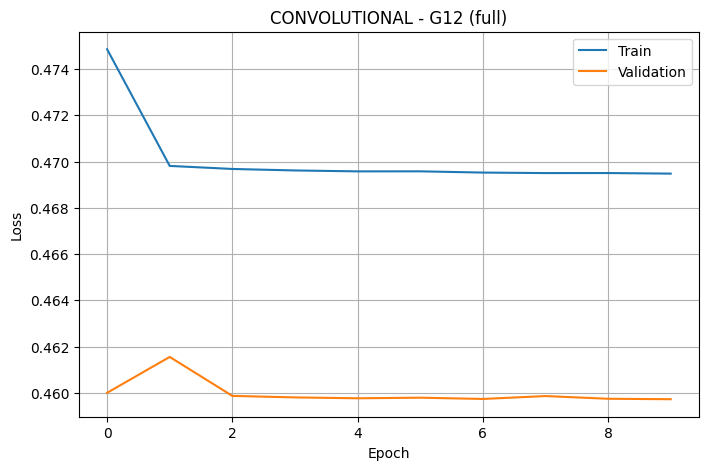


>>> Training basic...
Epoch 01 - Train Loss: 0.4883, Val Loss: 0.4714
Epoch 02 - Train Loss: 0.4812, Val Loss: 0.4712
Epoch 03 - Train Loss: 0.4810, Val Loss: 0.4709
Epoch 04 - Train Loss: 0.4808, Val Loss: 0.4710
Epoch 05 - Train Loss: 0.4748, Val Loss: 0.4599
Epoch 06 - Train Loss: 0.4697, Val Loss: 0.4599
Epoch 07 - Train Loss: 0.4697, Val Loss: 0.4599
Epoch 08 - Train Loss: 0.4697, Val Loss: 0.4599
Epoch 09 - Train Loss: 0.4696, Val Loss: 0.4599
Epoch 10 - Train Loss: 0.4696, Val Loss: 0.4599


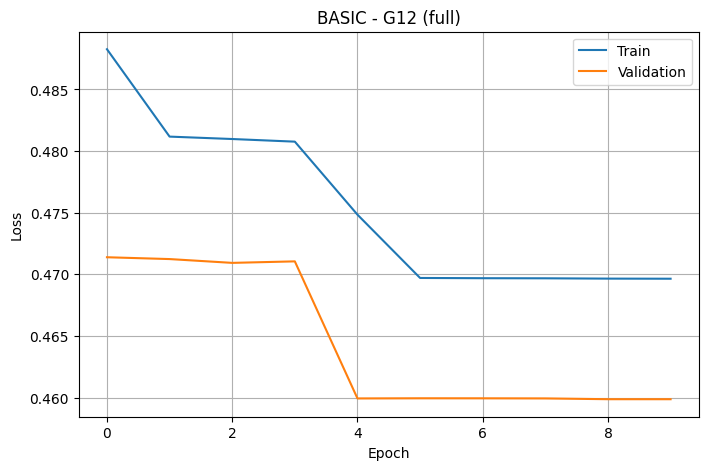


>>> Training sparse...
Epoch 01 - Train Loss: 0.9563, Val Loss: 0.4968
Epoch 02 - Train Loss: 0.5156, Val Loss: 0.4676
Epoch 03 - Train Loss: 0.4865, Val Loss: 0.4632
Epoch 04 - Train Loss: 0.4819, Val Loss: 0.4620
Epoch 05 - Train Loss: 0.4799, Val Loss: 0.4614
Epoch 06 - Train Loss: 0.4785, Val Loss: 0.4611
Epoch 07 - Train Loss: 0.4781, Val Loss: 0.4610
Epoch 08 - Train Loss: 0.4774, Val Loss: 0.4610
Epoch 09 - Train Loss: 0.4755, Val Loss: 0.4612
Epoch 10 - Train Loss: 0.4721, Val Loss: 0.4613


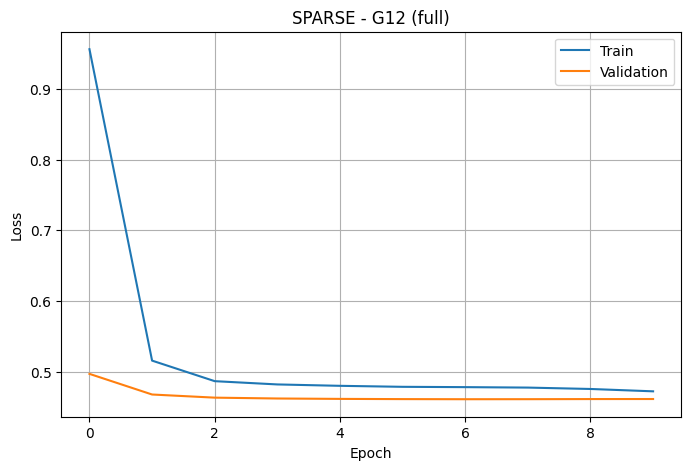


>>> Training denoising...
Epoch 01 - Train Loss: 0.4756, Val Loss: 0.4604
Epoch 02 - Train Loss: 0.4714, Val Loss: 0.4602
Epoch 03 - Train Loss: 0.4713, Val Loss: 0.4602
Epoch 04 - Train Loss: 0.4712, Val Loss: 0.4602
Epoch 05 - Train Loss: 0.4712, Val Loss: 0.4602
Epoch 06 - Train Loss: 0.4711, Val Loss: 0.4602
Epoch 07 - Train Loss: 0.4711, Val Loss: 0.4600
Epoch 08 - Train Loss: 0.4711, Val Loss: 0.4599
Epoch 09 - Train Loss: 0.4710, Val Loss: 0.4599
Epoch 10 - Train Loss: 0.4710, Val Loss: 0.4599


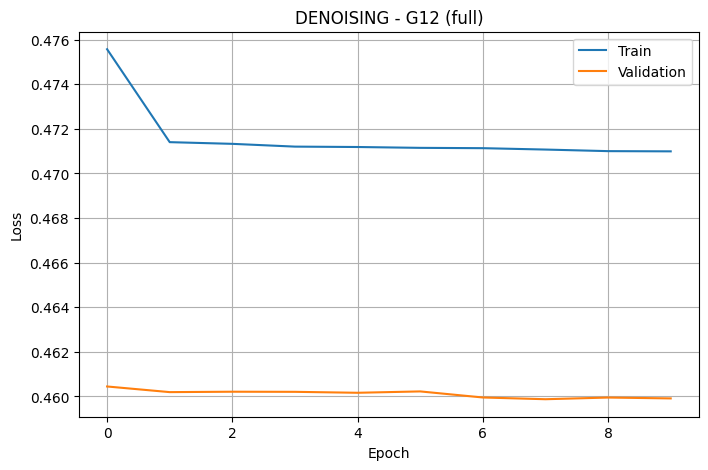


>>> Training vae...
Epoch 01 - Train Loss: 0.7405, Val Loss: 0.6290
Epoch 02 - Train Loss: 0.7237, Val Loss: 0.6310
Epoch 03 - Train Loss: 0.7227, Val Loss: 0.6198
Epoch 04 - Train Loss: 0.7222, Val Loss: 0.6191
Epoch 05 - Train Loss: 0.7214, Val Loss: 0.6264
Epoch 06 - Train Loss: 0.7212, Val Loss: 0.6297
Epoch 07 - Train Loss: 0.7207, Val Loss: 0.6192
Epoch 08 - Train Loss: 0.7205, Val Loss: 0.6226
Epoch 09 - Train Loss: 0.7201, Val Loss: 0.6215
Epoch 10 - Train Loss: 0.7199, Val Loss: 0.6180


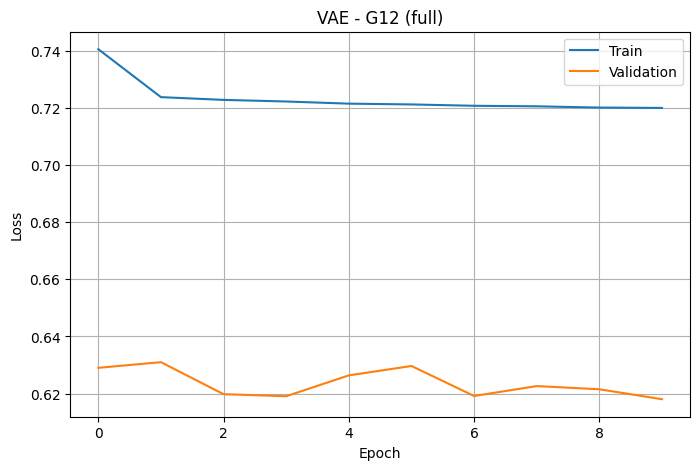


=== G12 | balanced ===

>>> Training convolutional...
Epoch 01 - Train Loss: 0.4733, Val Loss: 0.4601
Epoch 02 - Train Loss: 0.4697, Val Loss: 0.4599
Epoch 03 - Train Loss: 0.4696, Val Loss: 0.4598
Epoch 04 - Train Loss: 0.4696, Val Loss: 0.4598
Epoch 05 - Train Loss: 0.4696, Val Loss: 0.4598
Epoch 06 - Train Loss: 0.4696, Val Loss: 0.4598
Epoch 07 - Train Loss: 0.4695, Val Loss: 0.4597
Epoch 08 - Train Loss: 0.4695, Val Loss: 0.4598
Epoch 09 - Train Loss: 0.4695, Val Loss: 0.4599
Epoch 10 - Train Loss: 0.4695, Val Loss: 0.4597


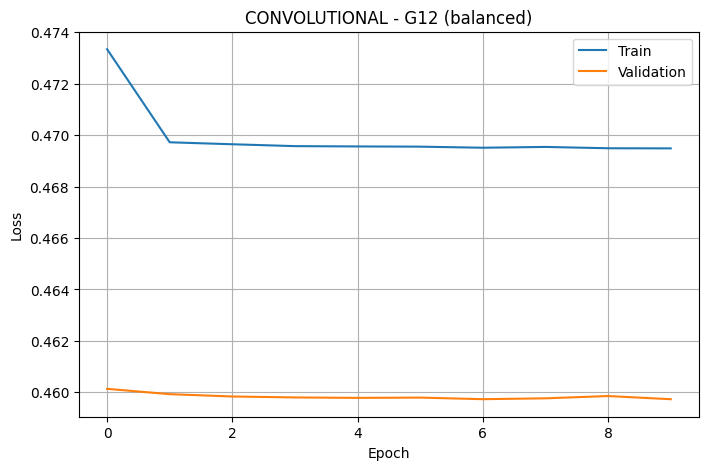


>>> Training basic...
Epoch 01 - Train Loss: 0.4774, Val Loss: 0.4604
Epoch 02 - Train Loss: 0.4700, Val Loss: 0.4601
Epoch 03 - Train Loss: 0.4698, Val Loss: 0.4600
Epoch 04 - Train Loss: 0.4697, Val Loss: 0.4599
Epoch 05 - Train Loss: 0.4697, Val Loss: 0.4599
Epoch 06 - Train Loss: 0.4696, Val Loss: 0.4600
Epoch 07 - Train Loss: 0.4696, Val Loss: 0.4600
Epoch 08 - Train Loss: 0.4696, Val Loss: 0.4598
Epoch 09 - Train Loss: 0.4696, Val Loss: 0.4599
Epoch 10 - Train Loss: 0.4696, Val Loss: 0.4599


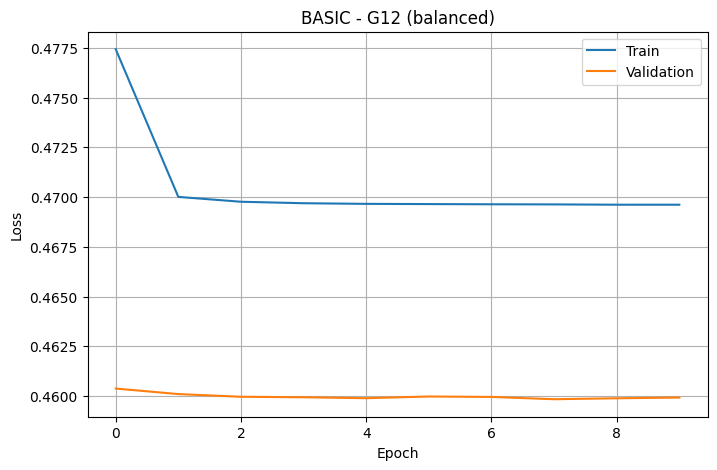


>>> Training sparse...
Epoch 01 - Train Loss: 0.9350, Val Loss: 0.4984
Epoch 02 - Train Loss: 0.5039, Val Loss: 0.4666
Epoch 03 - Train Loss: 0.4858, Val Loss: 0.4629
Epoch 04 - Train Loss: 0.4800, Val Loss: 0.4626
Epoch 05 - Train Loss: 0.4760, Val Loss: 0.4621
Epoch 06 - Train Loss: 0.4747, Val Loss: 0.4618
Epoch 07 - Train Loss: 0.4735, Val Loss: 0.4615
Epoch 08 - Train Loss: 0.4726, Val Loss: 0.4611
Epoch 09 - Train Loss: 0.4722, Val Loss: 0.4610
Epoch 10 - Train Loss: 0.4718, Val Loss: 0.4610


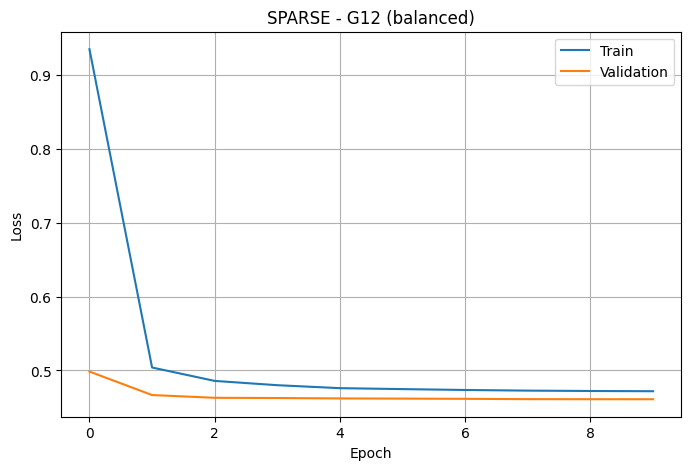


>>> Training denoising...
Epoch 01 - Train Loss: 0.4757, Val Loss: 0.4603
Epoch 02 - Train Loss: 0.4713, Val Loss: 0.4602
Epoch 03 - Train Loss: 0.4712, Val Loss: 0.4608
Epoch 04 - Train Loss: 0.4712, Val Loss: 0.4600
Epoch 05 - Train Loss: 0.4711, Val Loss: 0.4599
Epoch 06 - Train Loss: 0.4710, Val Loss: 0.4598
Epoch 07 - Train Loss: 0.4710, Val Loss: 0.4598
Epoch 08 - Train Loss: 0.4710, Val Loss: 0.4599
Epoch 09 - Train Loss: 0.4709, Val Loss: 0.4598
Epoch 10 - Train Loss: 0.4710, Val Loss: 0.4598


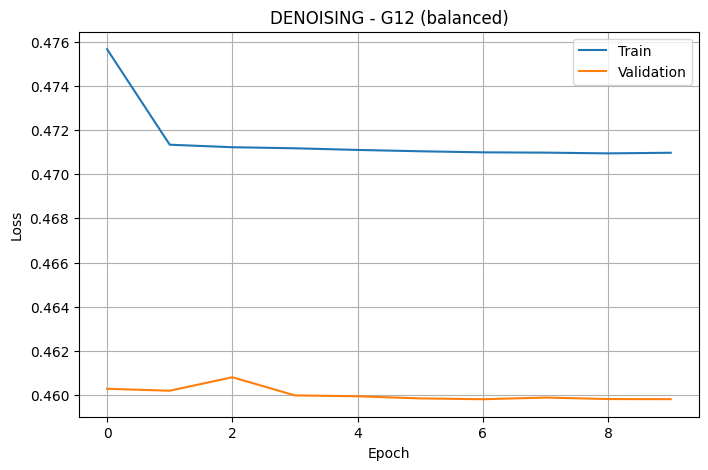


>>> Training vae...
Epoch 01 - Train Loss: 0.7408, Val Loss: 0.6279
Epoch 02 - Train Loss: 0.7213, Val Loss: 0.6154
Epoch 03 - Train Loss: 0.7195, Val Loss: 0.6185
Epoch 04 - Train Loss: 0.7189, Val Loss: 0.6158
Epoch 05 - Train Loss: 0.7183, Val Loss: 0.6182
Epoch 06 - Train Loss: 0.7176, Val Loss: 0.6120
Epoch 07 - Train Loss: 0.7174, Val Loss: 0.6195
Epoch 08 - Train Loss: 0.7173, Val Loss: 0.6140
Epoch 09 - Train Loss: 0.7172, Val Loss: 0.6172
Epoch 10 - Train Loss: 0.7174, Val Loss: 0.6242


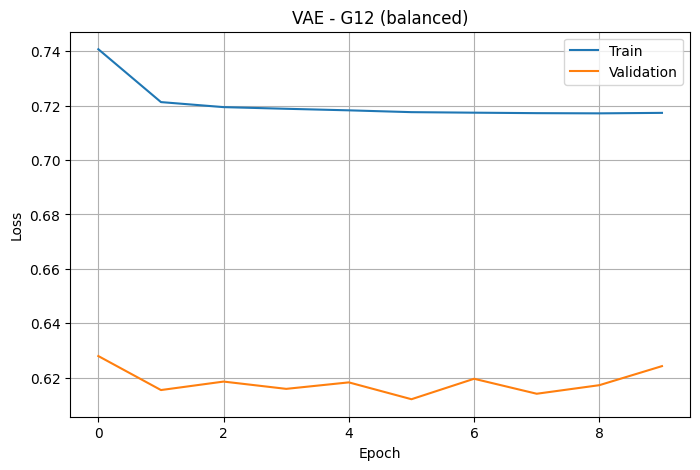

In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
datasets = {
    "credit_card": prepare_dataset("/kaggle/input/creditcardfraud/creditcard.csv", device, "credit_card"),
    "libra_bank": prepare_dataset("/kaggle/input/libra-bank/Libra_bank_3months_graph.csv", device, "libra_bank"),
    "G12": prepare_dataset("/kaggle/input/g12-bank-transfers/G12.csv", device, "G12")
}

model_classes = {
    "convolutional": ConvolutionalAutoencoder,
    "basic": BasicAutoencoder,
    "sparse": SparseAutoencoder,
    "denoising": DenoisingAutoencoder,
    "vae": VariationalAutoencoder
}

for dataset_name, variants in datasets.items():
    for variant_name, data in variants.items():
        input_dim = data["X_train"].shape[1]
        print(f"\n=== {dataset_name} | {variant_name} ===")

        for model_name, ModelClass in model_classes.items():
            print(f"\n>>> Training {model_name}...")

            model = ModelClass(input_dim=input_dim).to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)
            loss_fn = nn.MSELoss()

            is_vae = model_name == "vae"
            is_denoising = model_name == "denoising"
            is_sparse = model_name == "sparse"

            train_losses, val_losses = train_model(
                model,
                data["train_loader"],
                val_loader=data["val_loader"],
                loss_fn=loss_fn,
                optimizer=optimizer,
                scheduler=scheduler,
                is_vae=is_vae,
                is_denoising=is_denoising,
                is_sparse=is_sparse,
                noise_std=0.1,
                epochs=10
            )


            plot_losses(train_losses, val_losses, f"{model_name.upper()} - {dataset_name} ({variant_name})")

            os.makedirs("models", exist_ok=True)
            torch.save(model.state_dict(), f"models/{dataset_name}_{variant_name}_{model_name}.pt")


In [4]:
import torch
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, auc, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import joblib


Evaluation Function****

In [5]:
def evaluate_model(model, test_loader, y_true, threshold=3):
    model.eval()
    recon_errors = []

    with torch.no_grad():
        for batch in test_loader:
            x = batch[0]
            if hasattr(model, 'forward'):
                output = model(x)
                if isinstance(output, tuple):
                    output = output[0]
                loss = F.mse_loss(output, x, reduction='none')
                loss = loss.mean(dim=1)
                recon_errors.extend(loss.cpu().numpy())

    recon_errors = np.array(recon_errors)
    y_true = y_true.cpu().numpy()

    y_pred = (recon_errors > threshold).astype(int)

    fpr, tpr, _ = roc_curve(y_true, recon_errors)
    precision, recall, _ = precision_recall_curve(y_true, recon_errors)

    metrics = {
        "AUROC": roc_auc_score(y_true, recon_errors),
        "AUPRC": auc(recall, precision),
        "Threshold": threshold,
        "ConfusionMatrix": confusion_matrix(y_true, y_pred),
        "ClassificationReport": classification_report(y_true, y_pred, output_dict=True)
    }

    curves = {
        "fpr": fpr,
        "tpr": tpr,
        "precision": precision,
        "recall": recall,
        "errors": recon_errors,
        "y_true": y_true
    }

    return metrics, curves, y_pred


Loading already saved models****

In [19]:
model_names = ["basic", "convolutional", "sparse", "denoising", "vae"]
model_dir = "/kaggle/input/autoencoders/pytorch/default/1/Models"

credit_card = prepare_dataset("/kaggle/input/creditcardfraud/creditcard.csv", device, "credit_card")
libra_bank = prepare_dataset("/kaggle/input/libra-bank/Libra_bank_3months_graph.csv", device, "libra_bank")
G12 = prepare_dataset("/kaggle/input/g12-bank-transfers/G12.csv", device, "G12")

datasets = {
    "credit_card": credit_card,
    "libra_bank": libra_bank,
    "G12": G12
}
def load_model(model_name, input_dim):
    if model_name == "basic":
        return BasicAutoencoder(input_dim)
    elif model_name == "sparse":
        return SparseAutoencoder(input_dim)
    elif model_name == "convolutional":
        return ConvolutionalAutoencoder(input_dim)
    elif model_name == "denoising":
        return DenoisingAutoencoder(input_dim)
    elif model_name == "vae":
        return VariationalAutoencoder(input_dim)
    else:
        raise ValueError("Unknown model")

loaded_models = {}
types = ["full", "balanced"]
for t in types:
    for dataset_name, dataset in datasets.items():
        input_dim = dataset['full']['X_train'].shape[1]
        for model_name in model_names:
            model = load_model(model_name, input_dim).to(device)
            path = os.path.join(model_dir, f"{dataset_name}_{t}_{model_name}.pt")
            model.load_state_dict(torch.load(path, map_location=device, weights_only=True))
            model.eval()
            loaded_models[(model_name, dataset_name, t)] = model


All Metrics and Confusion Matrix Output****

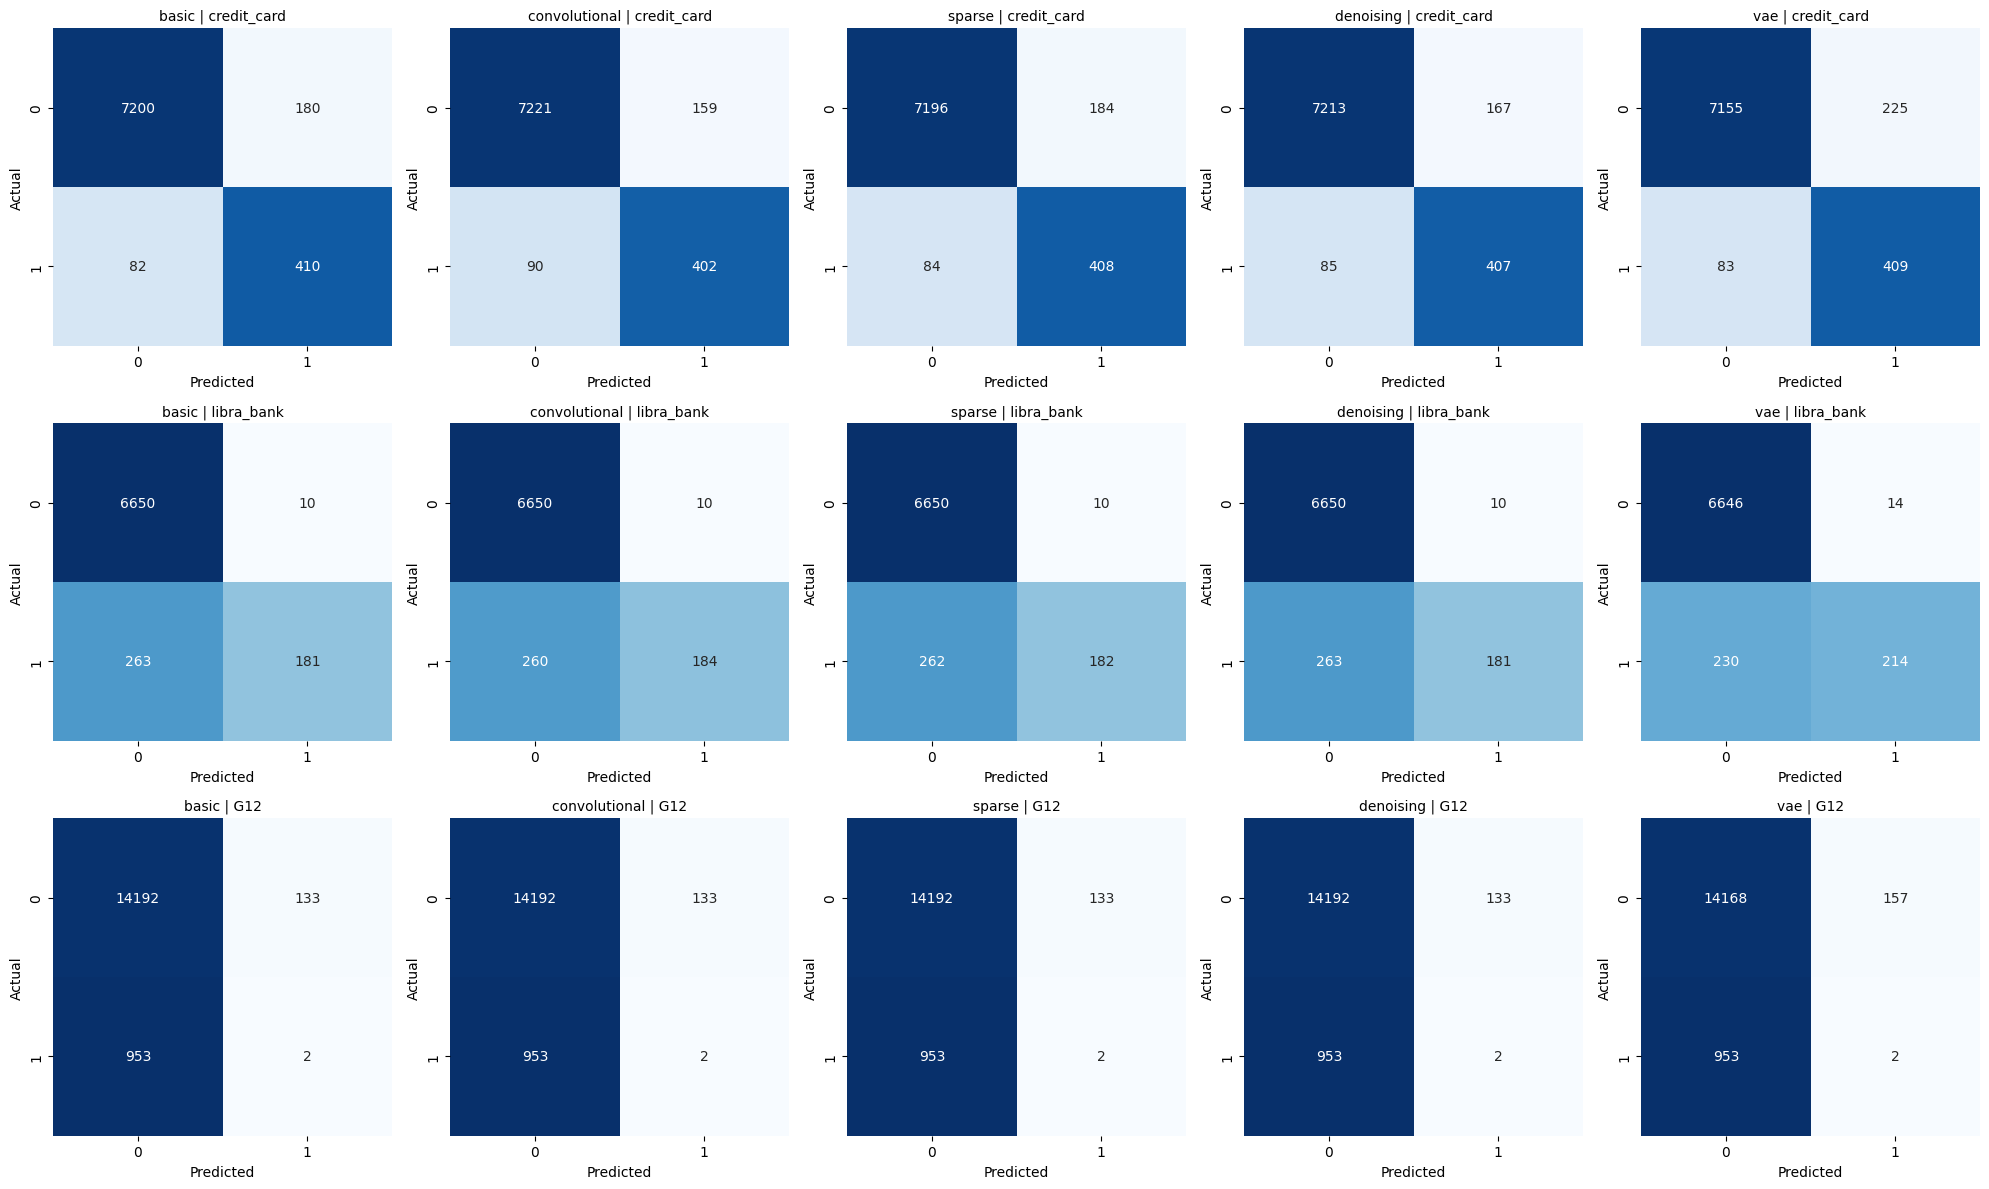

In [21]:

import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

credit_card = prepare_dataset("/kaggle/input/creditcardfraud/creditcard.csv", device, "credit_card")
libra_bank = prepare_dataset("/kaggle/input/libra-bank/Libra_bank_3months_graph.csv", device, "libra_bank")
G12 = prepare_dataset("/kaggle/input/g12-bank-transfers/G12.csv", device, "G12")

datasets = {
    "credit_card": credit_card,
    "libra_bank": libra_bank,
    "G12": G12
}

def evaluate_models_with_threshold_sweep(
    loaded_models, datasets, thresholds=np.linspace(3, 3, 1), save_path=None
):
    results = []
    all_confusion_matrices = {}

    for (model_name, dataset_name, version), model in loaded_models.items():
        data = datasets[dataset_name][version]
        y_test_tensor = data["y_test"]
        y_test_np = y_test_tensor.cpu().numpy()

        nr_of_frauds = (y_test_np == 1).sum()
        contamination_rate = nr_of_frauds / len(y_test_np)

        best_recall = 0
        best_f1 = 0
        best_threshold = 0
        best_metrics = {}
        best_conf_matrix = None
        
        for threshold in thresholds:
            metrics, _, y_pred = evaluate_model(
                model, data["test_loader"], data["y_test"], threshold=threshold
            )
        
            f1 = metrics["ClassificationReport"].get('1.0', {}).get('f1-score', 0)
            recall = metrics["ClassificationReport"].get('1.0', {}).get('recall', 0)
        
            if dataset_name == "G12":
                if f1 > best_f1:
                    best_recall = recall
                    best_f1 = f1
                    best_threshold = threshold
                    best_metrics = metrics
                    y_pred_np = y_pred.cpu().numpy() if hasattr(y_pred, "cpu") else y_pred
                    best_conf_matrix = metrics.get("ConfusionMatrix", confusion_matrix(y_test_np, y_pred_np))
            else:
                if f1 > 0.2 and recall > best_recall:
                    best_recall = recall
                    best_f1 = f1
                    best_threshold = threshold
                    best_metrics = metrics
                    y_pred_np = y_pred.cpu().numpy() if hasattr(y_pred, "cpu") else y_pred
                    best_conf_matrix = metrics.get("ConfusionMatrix", confusion_matrix(y_test_np, y_pred_np))


        identifier = f"{model_name} | {dataset_name}"
        all_confusion_matrices[identifier] = best_conf_matrix

        if best_metrics and "ClassificationReport" in best_metrics:
            result_row = {
                "Model": model_name,
                "Dataset": dataset_name,
                "Version": version,
                "AUROC": best_metrics.get("AUROC", np.nan),
                "AUPRC": best_metrics.get("AUPRC", np.nan),
                "Threshold": round(best_threshold, 3) if best_threshold is not None else np.nan,
                "Precision": best_metrics["ClassificationReport"].get('1.0', {}).get('precision', 0),
                "Recall": best_metrics["ClassificationReport"].get('1.0', {}).get('recall', 0),
                "F1-Score": best_f1,
                "Nr_Of_Frauds": nr_of_frauds,
                "ContaminationRate": round(contamination_rate, 6),
            }
        else:
            result_row = {
                "Model": model_name,
                "Dataset": dataset_name,
                "Version": version,
                "AUROC": np.nan,
                "AUPRC": np.nan,
                "Threshold": np.nan,
                "Precision": 0,
                "Recall": 0,
                "F1-Score": 0,
                "Nr_Of_Frauds": nr_of_frauds,
                "ContaminationRate": round(contamination_rate, 6),
            }


        results.append(result_row)

    results_df = pd.DataFrame(results)

    return results_df, all_confusion_matrices

results_df, all_confusion_matrices = evaluate_models_with_threshold_sweep(loaded_models, datasets)


def plot_confusion_matrices(conf_matrices, save_path="confusion_matrices.png"):
    num_matrices = len(conf_matrices)
    cols = 5
    rows = (num_matrices + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(20, 4 * rows))
    axes = axes.flatten()

    for idx, (identifier, matrix) in enumerate(conf_matrices.items()):
        ax = axes[idx]
        matrix_norm = matrix.astype(float) / matrix.sum(axis=1, keepdims=True)
        sns.heatmap(matrix_norm, annot=matrix, fmt='d', cmap='Blues', ax=ax, cbar=False, vmin=0, vmax=1)
        ax.set_title(identifier, fontsize=10)
        ax.set_xlabel("Predicted")
        ax.set_ylabel("Actual")

    for j in range(idx + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.savefig(save_path, dpi=500, bbox_inches='tight')  
    plt.show()

plot_confusion_matrices(all_confusion_matrices, save_path="confusion_matrices.pdf")



Printing Results on all Metrics

In [23]:
results_df = results_df.sort_values(by=["Dataset", "Version", "Model"])
results_df.style.set_caption("Autoencoder Performance on Datasets")
from IPython.display import display

display(results_df.style.set_caption("Autoencoder Performance on Datasets"))

def plot_curves(curves_dict, model_name, dataset_name, version):
    fpr = curves_dict["fpr"]
    tpr = curves_dict["tpr"]
    precision = curves_dict["precision"]
    recall = curves_dict["recall"]

    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label="ROC Curve")
    plt.title(f"ROC - {model_name} on {dataset_name} ({version})")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label="PR Curve")
    plt.title(f"Precision-Recall - {model_name} on {dataset_name} ({version})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()

    plt.tight_layout()
    plt.show()
    
metrics, curves = evaluate_model(loaded_models[("sparse", "credit_card", "balanced")], credit_card["balanced"]["test_loader"], credit_card["balanced"]["y_test"])


,Model,Dataset,Version,AUROC,AUPRC,Threshold,Precision,Recall,F1-Score,Nr_Of_Frauds,ContaminationRate
25,basic,G12,balanced,0.746752,0.113731,3.000000,0.014815,0.002094,0.003670,955,0.062500
26,convolutional,G12,balanced,0.676552,0.096447,3.000000,0.014815,0.002094,0.003670,955,0.062500
28,denoising,G12,balanced,0.735572,0.109213,3.000000,0.014815,0.002094,0.003670,955,0.062500
27,sparse,G12,balanced,0.743852,0.112138,3.000000,0.014815,0.002094,0.003670,955,0.062500
29,vae,G12,balanced,0.759330,0.122147,3.000000,0.012579,0.002094,0.003591,955,0.062500
10,basic,G12,full,0.762243,0.020428,3.000000,0.002522,0.002094,0.002288,955,0.010032
11,convolutional,G12,full,0.580426,0.011468,3.000000,0.002525,0.002094,0.002290,955,0.010032
13,denoising,G12,full,0.736315,0.018464,3.000000,0.002519,0.002094,0.002287,955,0.010032
12,sparse,G12,full,0.750272,0.019378,3.000000,0.002525,0.002094,0.002290,955,0.010032
14,vae,G12,full,0.782818,0.024430,3.000000,0.003268,0.003141,0.003203,955,0.010032


ValueError: too many values to unpack (expected 2)

AUPRC and Bar Plot****

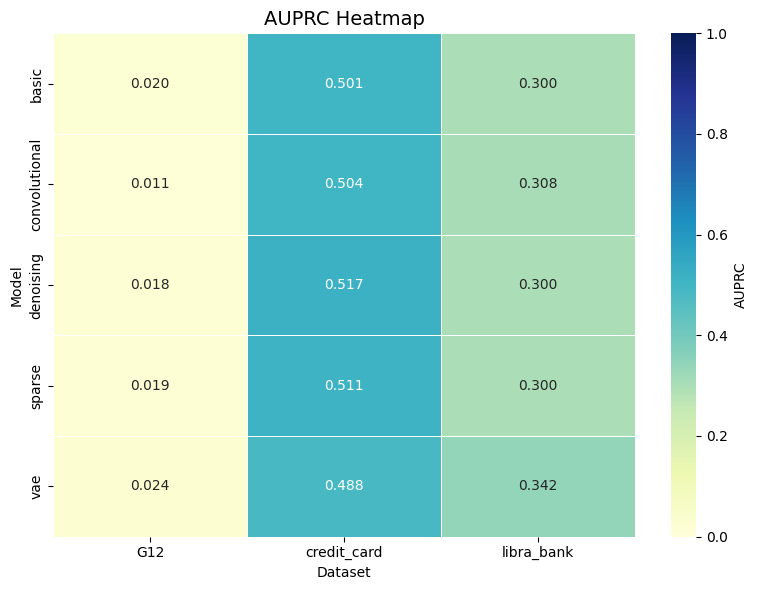

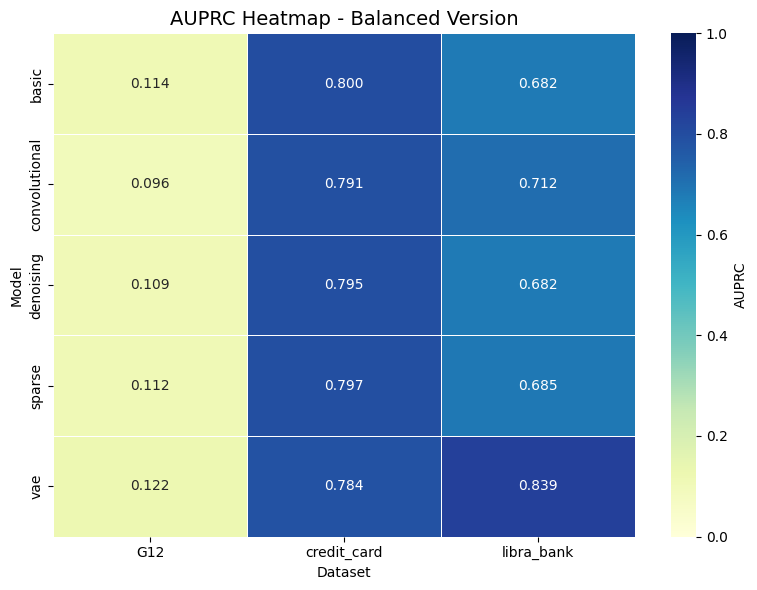

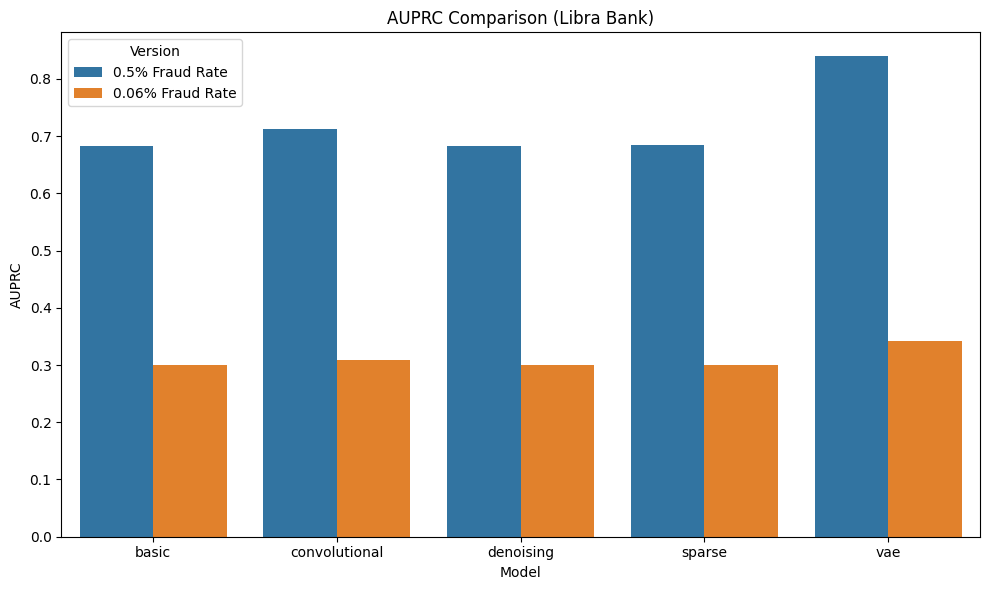

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

auprc_df = results_df[["Model", "Dataset", "Version", "AUPRC", "F1-Score", "Recall", "Precision"]]

full_data = auprc_df[auprc_df["Version"] == "full"].pivot(index="Model", columns="Dataset", values="AUPRC")
balanced_data = auprc_df[auprc_df["Version"] == "balanced"].pivot(index="Model", columns="Dataset", values="AUPRC")

def plot_heatmap(data, title, cmap="YlGnBu", filename="heatmapAUPRC.png", dpi=400):
    plt.figure(figsize=(8, 6))
    sns.heatmap(data, annot=True, fmt=".3f", cmap=cmap, vmin = 0, vmax = 1, linewidths=0.5, cbar_kws={'label': 'AUPRC'})
    plt.title(title, fontsize=14)
    plt.ylabel("Model")
    plt.xlabel("Dataset")
    plt.tight_layout()
    plt.savefig(filename, dpi=dpi)
    plt.show()


plot_heatmap(full_data, "AUPRC Heatmap", filename="AUPRC_full.png")
plot_heatmap(balanced_data, "AUPRC Heatmap - Balanced Version", filename="AUPRC_balanced.png")

subset = results_df[results_df["Dataset"] == "libra_bank"]

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=subset, x="Model", y="AUPRC", hue="Version")
plt.title("AUPRC Comparison (Libra Bank)")
plt.ylabel("AUPRC")
plt.xlabel("Model")
plt.legend(title="Version")
new_labels = ["0.5% Fraud Rate","0.06% Fraud Rate"]  
for t, l in zip(ax.legend_.texts, new_labels):
    t.set_text(l)
plt.tight_layout()
plt.savefig("BarPlot.png", dpi=400)
plt.show()


AUPRC Comparison when increasing Beta/noise

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

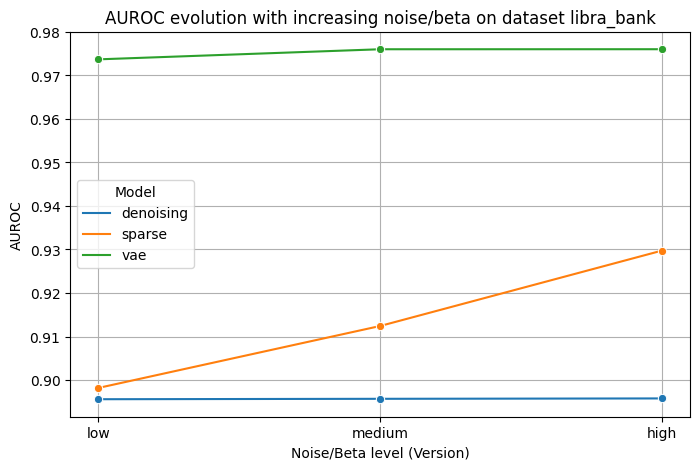

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

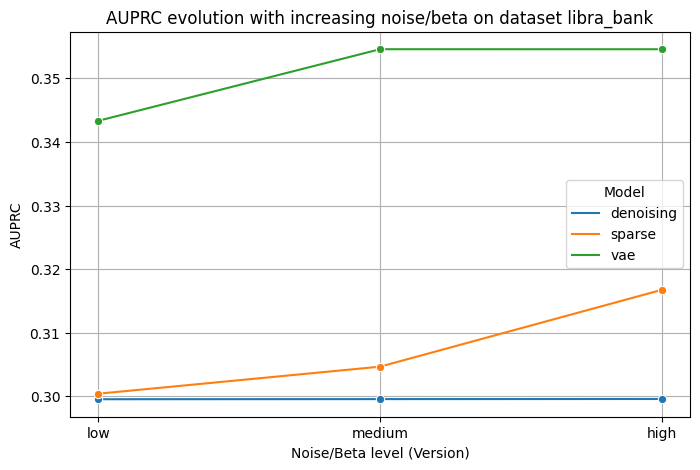

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

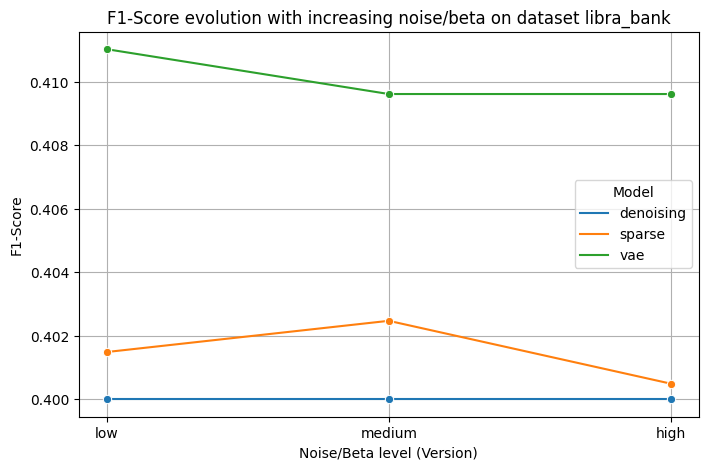

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


df = results_df
df['Version'] = pd.Categorical(df['Version'], categories=['low', 'medium', 'high'], ordered=True)

dataset_to_plot = "G12"
df_subset = df[df['Dataset'] == dataset_to_plot]

metrics = ['AUROC', 'AUPRC', 'F1-Score']

for metric in metrics:
    plt.figure(figsize=(8, 5))
    sns.lineplot(data=df_subset, x='Version', y=metric, hue='Model', marker='o')
    plt.title(f'{metric} evolution with increasing noise/beta on dataset {dataset_to_plot}')
    plt.ylabel(metric)
    plt.xlabel('Noise/Beta level (Version)')
    plt.legend(title='Model')
    plt.grid(True)
    plt.savefig(f'{dataset_to_plot}_{metric}_evolution.png', dpi=300)
    plt.show()
